# Task 8: Fake news prediction
- The Fake News Prediction Dataset features both real and fake news, providing a
basis for predictive modeling to identify misinformation. With columns including Title, Text, and Label (Fake or Real), it addresses the pervasive issue of false or
misleading information in news.
- The dataset supports efforts to enhance information integrity, combat fake news,
and promote media literacy.

# Fake news dataset information

Fake news or hoax news is false or misleading information presented as news. Fake news often has the aim of damaging the reputation of a person or entity, or making money through advertising revenue.

This dataset is having Both Fake and Real news.

The columns present in the dataset are:-

1) `Title` -> Title of the News

2) `Text` -> Text or Content of the News

3) `Label` -> Labelling the news as Fake or Real

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neattext.functions as nfx
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, cross_val_score
from sklearn.metrics import classification_report, make_scorer, f1_score, confusion_matrix, recall_score
from sklearn.pipeline import FeatureUnion, Pipeline, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from ydata_profiling import ProfileReport
from warnings import filterwarnings
from wordcloud import WordCloud

filterwarnings('ignore')
%matplotlib inline

In [2]:
# # Local PC data retrieving
# from kaggle.api.kaggle_api_extended import KaggleApi

# # Initialize the Kaggle API
# api = KaggleApi()
# api.authenticate()

# # Download the dataset
# api.dataset_download_files('rajatkumar30/fake-news', path='D:/Estiven/Datos/Proyectos/CognoRise_Infotech/data/raw', unzip=True)

# Read the data as a pandas dataframe
df = pd.read_csv("D:/Estiven/Datos/Proyectos/CognoRise_Infotech/data/raw/news.csv")
df.drop('Unnamed: 0', axis=1, inplace=True) # Dropping useless index column

In [3]:
# # Google Colab data retrieving
# from google.colab import files

# # Uploading the Kaggle API key (kaggle.json) to Colab
# files.upload()

# # Move the uploaded file to the required location of Colab
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d rajatkumar30/fake-news #dataset download
# !unzip -q creditcardfraud.zip #unzipping the data

# df = pd.read_csv("news.csv") #reading data as pandas dataframe

In [4]:
print('Simple description of the data columns:')
df.describe()

Simple description of the data columns:


title  \
count                            6335   
unique                           6256   
top     OnPolitics | 's politics blog   
freq                                5   

                                                     text label  
count                                                6335  6335  
unique                                               6060     2  
top     Killing Obama administration rules, dismantlin...  REAL  
freq                                                   58  3171

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 148.6+ KB


In [6]:
report = ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# EDA, (Exploratory data analysis)

In [7]:
df.head(3)

title  \
0                       You Can Smell Hillary’s Fear   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2        Kerry to go to Paris in gesture of sympathy   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL

Information about nulls, infinite values and duplicates

In [8]:
nulls = df.isnull()
null_rows, null_cols = np.where(nulls)

print(f'Total of null data: {df.isnull().sum().sum()}')
print(f'Total of duplicated data: {df.duplicated().sum()}')

print(f'Rows with null values: {null_rows.sum()}')
print(f'Columns with null values: {null_cols.sum()}')

Total of null data: 0
Total of duplicated data: 29
Rows with null values: 0
Columns with null values: 0


In [9]:
duplicated_rows = df.duplicated()

print(f'Percentage of total duplicated data: {duplicated_rows.mean() * 100:.1f}%')

# Eliminating duplicated data
df = df.copy().drop_duplicates()

Percentage of total duplicated data: 0.5%


In [10]:
print(f'Data by label: {df.label.value_counts()}')

# Treatment to change real for 0 and fake for 1
df.label = df.label.map({'REAL': 0, 'FAKE': 1})
print(df.label.unique())

Data by label: label
REAL    3154
FAKE    3152
Name: count, dtype: int64
[1 0]


# Text cleaning

The title might not be that important when deciding if a new is fake or not, so I will delete it

In [11]:
df = df.copy().drop(['title'], axis=1)

In [12]:
df['text_length'] = df['text'].apply(len)
df['text_num_capital_letters'] = df['text'].apply(lambda s: sum([1 for c in s if c.isupper()]))
df['text_num_words'] = df['text'].apply(lambda s: len(s.split()))
df['text_avg_word_length'] = df['text'].apply(lambda s: sum(len(word) for word in s.split()) / len(s.split()) if len(s.split()) > 0 else 0)
df['text_num_special_chars'] = df['text'].apply(lambda s: sum([1 for c in s if not c.isalnum() and not c.isspace()]))

df.head()

text  label  text_length  \
0  Daniel Greenfield, a Shillman Journalism Fello...      1         7549   
1  Google Pinterest Digg Linkedin Reddit Stumbleu...      1         2654   
2  U.S. Secretary of State John F. Kerry said Mon...      0         2559   
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...      1         2673   
4  It's primary day in New York and front-runners...      0         1860   

   text_num_capital_letters  text_num_words  text_avg_word_length  \
0                       314            1296              4.776235   
1                        96             446              4.917040   
2                        96             431              4.883991   
3                       139             404              5.554455   
4                        77             317              4.776025   

   text_num_special_chars  
0                     147  
1                      78  
2                      55  
3                      98  
4                      65

In [13]:
def clean_text(text):
    text = str(text).lower()
    text = nfx.remove_special_characters(text)
    text = nfx.remove_stopwords(text)
    text = nfx.remove_urls(text)
    text = nfx.remove_puncts(text)
    text = nfx.remove_emails(text)
    text = nfx.remove_userhandles(text)
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
df.drop(['text'], axis=1, inplace=True)
df.head()

label  text_length  text_num_capital_letters  text_num_words  \
0      1         7549                       314            1296   
1      1         2654                        96             446   
2      0         2559                        96             431   
3      1         2673                       139             404   
4      0         1860                        77             317   

   text_avg_word_length  text_num_special_chars  \
0              4.776235                     147   
1              4.917040                      78   
2              4.883991                      55   
3              5.554455                      98   
4              4.776025                      65   

                                        cleaned_text  
0  daniel greenfield shillman journalism fellow f...  
1  google pinterest digg linkedin reddit stumbleu...  
2  secretary state john f kerry said monday stop ...  
3  kaydee king kaydeeking november 9 2016 lesson ...  
4  primary day new york frontrunners hillary clin...

In [14]:
report_new_data = ProfileReport(df)
report_new_data

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

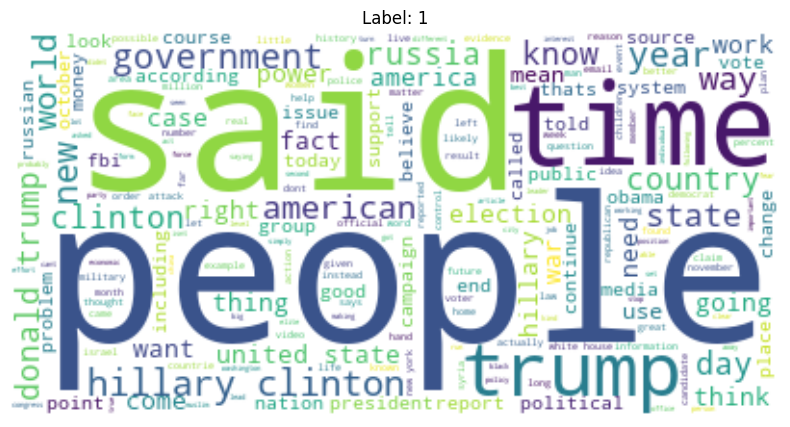

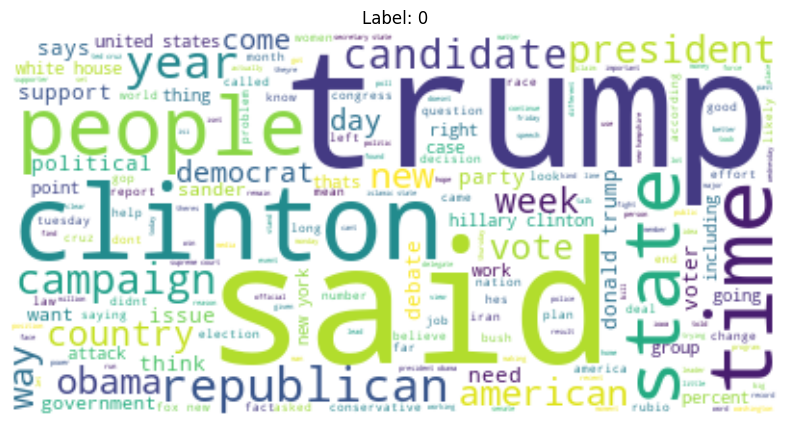

In [15]:
# Assuming 'label' is the name of your label column
labels = df['label'].unique()

for label in labels:
    text = " ".join(review for review in df[df['label'] == label]['cleaned_text'])
    wordcloud = WordCloud(background_color='white').generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Label: {label}')
    plt.show()

# Model implementation

In [16]:
# Split the dataset into features (X) and target variable (y)
X = df.drop('label', axis=1)
y = df['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
# Define function to select text columns
def get_text_data(df):
    return df['cleaned_text']

# Define function to select numerical columns
def get_numeric_data(df):
    return df.drop(['cleaned_text'], axis=1)

# Define preprocessing steps
text_features = Pipeline([
    ('selector', FunctionTransformer(get_text_data, validate=False)),
    ('vectorizer', TfidfVectorizer())
])

numeric_features = Pipeline([
    ('selector', FunctionTransformer(get_numeric_data, validate=False)),
    ('scaler', MinMaxScaler())
])

# Combine text and numeric processing steps
preprocess = FeatureUnion(transformer_list=[
    ('text_features', text_features),
    ('numeric_features', numeric_features)
])

# Define model
model = RandomForestClassifier()

# Create pipeline
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('classifier', model)
])

# Parameter grid to search best parameters
param_distributions = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__criterion': ['gini', 'entropy']
}

# TO CONCLUSIONS: ASSESING F1 SCORE BECAUSE IT IS RELATED TO FALSE NEGATIVES
# Define scorer
scorer = make_scorer(f1_score)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(pipeline, param_distributions, scoring=scorer, cv=3, n_iter=10, random_state=42)

# Fit and tune model
random_search.fit(X_train, y_train)

# Get best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

best_model = random_search.best_estimator_
predictions = best_model.predict(X_test)

Best parameters: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 20, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}


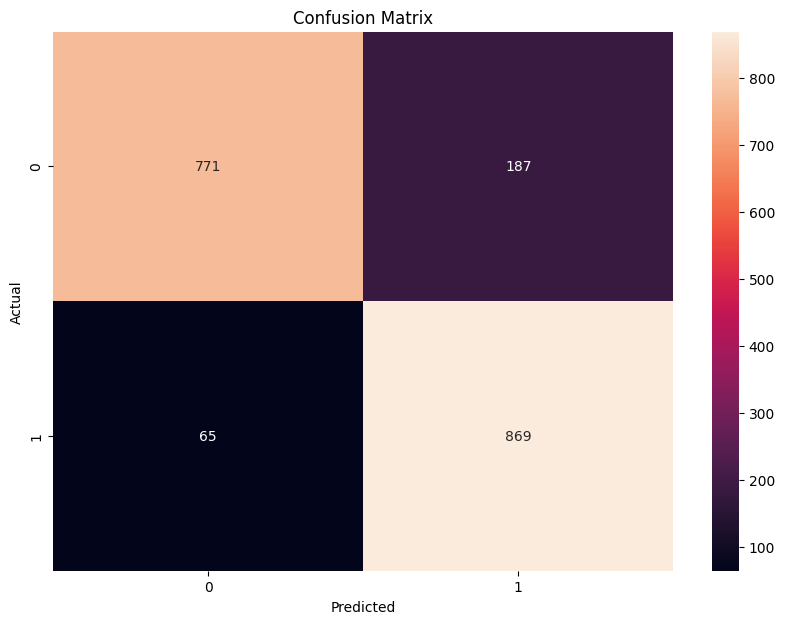

In [18]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [31]:
# Predict on training set
train_predictions = best_model.predict(X_train)

# Generate classification report for training set
train_report = classification_report(y_train, train_predictions)
print(f"Training Classification Report:\n{train_report}\n")

# Generate classification report for testing set
test_report = classification_report(y_test, predictions)
print(f"Testing Classification Report:\n{test_report}")

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      2196
           1       0.89      1.00      0.94      2218

    accuracy                           0.94      4414
   macro avg       0.94      0.93      0.93      4414
weighted avg       0.94      0.94      0.93      4414


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       958
           1       0.86      0.87      0.87       934

    accuracy                           0.87      1892
   macro avg       0.87      0.87      0.87      1892
weighted avg       0.87      0.87      0.87      1892



In [28]:
from sklearn.metrics import confusion_matrix

# Get predicted probabilities
probs = best_model.predict_proba(X_test)

# Define threshold
threshold = 0.54  # Adjust this value to suit your needs

# Make predictions based on the adjusted threshold
predictions = [1 if prob[1] > threshold else 0 for prob in probs]

# Get confusion matrix
cm_new = confusion_matrix(y_test, predictions)

print(cm_new)

[[831 127]
 [125 809]]


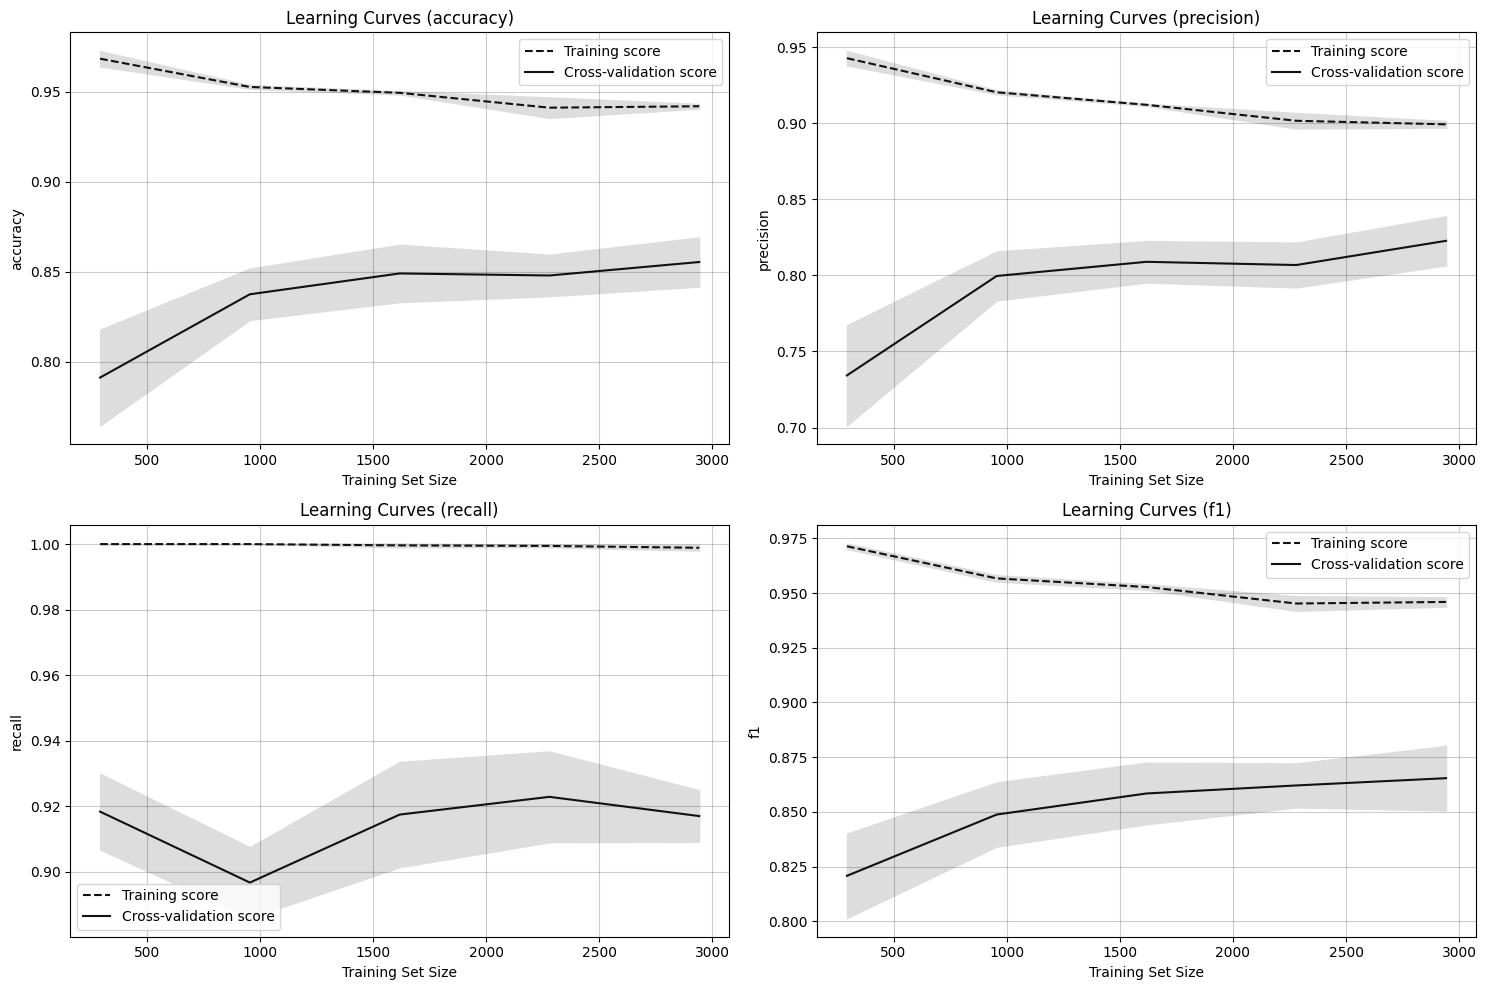

In [19]:
# Define metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']

# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()  # Flattening the 2D array

# Plot learning curves for each metric
for i, metric in enumerate(metrics):
    train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=3, scoring=metric)
    
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Draw lines
    axs[i].plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    axs[i].plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    # Draw bands
    axs[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    axs[i].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    axs[i].set_title(f'Learning Curves ({metric})')
    axs[i].set_xlabel('Training Set Size')
    axs[i].set_ylabel(metric)
    axs[i].legend(loc='best')
    axs[i].grid(True, alpha=0.2, color='black')

# Improve layout
plt.tight_layout()
plt.show()